# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version.
As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation.
However, we can also look at metrics that give us additional information about the behavior of the model over time.
Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design,
fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model,
and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50,
then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'`
of perform_experiments.
Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit.
In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios,
where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`.
Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices?
Are these sample sizes sufficient for a stable estimation of the indices?
You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html)
function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function.

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html)
included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point,
use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from patsy.highlevel import dmatrices

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, ScalarOutcome, perform_experiments, ema_logging, SequentialEvaluator)
from ema_workbench.analysis import plotting, plotting_util
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

from ema_workbench import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)

def pred_prey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, 
             final_time=365, reps=1):

    #Initial values
    predators = np.zeros((reps, int(final_time/dt)+1))
    prey = np.zeros((reps, int(final_time/dt)+1))
    sim_time = np.zeros((reps, int(final_time/dt)+1))
    
    for r in range(reps):

        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

    #Calculate the time series
    for t in range(0, sim_time.shape[1]-1):

        dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
        dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

        prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
        predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
        sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}


In [2]:
# GSA method: Linear regression

# Instantiate Python model
modelPython = Model('PredPreyPython', function=pred_prey) # instantiate the model

modelPython.uncertainties = [RealParameter ('prey_birth_rate', 0.015, 0.035),
                                 RealParameter ('predation_rate', 0.0005, 0.003),
                                 RealParameter ('predator_efficiency', 0.001, 0.004),
                                 RealParameter ('predator_loss_rate', 0.04, 0.08)
                                 ]

modelPython.outcomes = [TimeSeriesOutcome('TIME'),
                            TimeSeriesOutcome('predators'),
                            TimeSeriesOutcome('prey')]

def generate_regression(X, y):
    # Add column of ones to the end of the dependent variable matrix
    X = sm.add_constant(X, prepend=False)

    # Fit and summarize OLS model
    mod = sm.OLS(y, X)
    res = mod.fit()
    print(res.summary())

def generate_regression_single(x, y):
    # Add column of ones to the end of the dependent variable matrix
    x = sm.add_constant(x, prepend=False)

    # Fit and summarize OLS model
    mod = sm.OLS(y, x)
    res = mod.fit()
    print(res.summary())

# Function expects an instance of a model and plots it
def plot_lotka_volterra(model_instance):

    with SequentialEvaluator(model_instance) as evaluator:
        sa_results = evaluator.perform_experiments(scenarios=50, uncertainty_sampling=LHS)

    experiments, outcomes = sa_results

    # Squeeze outcomes
    outcomes_squeezed = {}

    for key in outcomes:
        outcomes_squeezed[key] = np.squeeze(outcomes[key])

    # Store final values of prey outcome
    prey_final = []
    prey_mean = []
    prey_std = []

    # Iterate through rows of outcome numpy array (experiments) to calculate indicators
    for experiment_row in outcomes_squeezed["prey"]:
        prey_final.append(experiment_row[-1]) # Get last element
        prey_mean.append(np.mean(experiment_row))
        prey_std.append(np.std(experiment_row))

    # Collect indicators in dictionary to calculate regression for each of them
    indicators = {'prey_final':prey_final, 'prey_mean':prey_mean, 'prey_std':prey_std}

    # Calculate regression to investigate relationship between uncertainties and final number of preys after one year, the mean value of preys, and the standard deviation of preys
    for indicator_key in indicators.keys():
        generate_regression_single(experiments["prey_birth_rate"], indicators[indicator_key])
        generate_regression_single(experiments["predation_rate"], indicators[indicator_key])
        generate_regression_single(experiments["predator_efficiency"], indicators[indicator_key])
        generate_regression_single(experiments["predator_loss_rate"], indicators[indicator_key])
        
    return prey_final, prey_mean, prey_std

  
prey_final, prey_mean, prey_std = plot_lotka_volterra(modelPython)


[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 25 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 35 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 45 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] experiments finished


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.2899
Date:                Thu, 13 May 2021   Prob (F-statistic):              0.593
Time:                        20:25:00   Log-Likelihood:                -224.61
No. Observations:                  50   AIC:                             453.2
Df Residuals:                      48   BIC:                             457.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
prey_birth_rate  -291.3538    541.133     

# Linear regression interpretation
What can we conclude about the behavior of the model, and about the importance of the different inputs?

Based on OLS regression results, it appears that the behaviour of the model is non-linear. The R2 values generated for each outcome indicators against all input parameters (thus 12 R2 values in total) are all closer to zero than to one, and therefore, a linear regression model fits the outcomes of interest poorly. However, an exception is the linear regression model fitted between predator efficieny (input) and mean values of prey over time (output), of which the model has a R2 value of 0.701, and thus reveals that 70% of the data fits the regression model. This model also has a slope of -1.333e+04, revealing the importance of predator efficiency on the results of mean values of prey over time. However, importantce of the other inputs cannot be evaluated based on the slope due to the low fitting shown by low R2 values.

/Users/wenyuc/opt/anaconda3/lib/python3.8/site-packages/SALib/sample/saltelli.py:52: FutureWarning: 
        Convergence properties of the Sobol' sequence is only valid if `N` = 2^n.
        SALib will continue on, but results may have issues.
        In future, this will raise an error.
        
  warnings.warn(msg, FutureWarning)
[MainProcess/INFO] performing 500 scenarios * 1 policies * 1 model(s) = 500 experiments
[MainProcess/INFO] performing experiments sequentially


Performing 50 scenarios:


[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] experiments finished
/Users/wenyuc/opt/anaconda3/lib/python3.8/site-packages/SALib/sample/saltelli.py:52: FutureWarning: 
        Convergence properties of the Sobol' sequence is only valid if `N` = 2^n.
        SALib will continue on, but results may have issues.
        In future, this will raise an error.
        
  warnings.warn(msg, FutureWarning)
[MainProcess/INFO] performing 2500 scenarios * 1 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially



Final value of prey

                           ST   ST_conf        S1   S1_conf
predation_rate       0.124075  0.094277  0.034042  0.106871
predator_efficiency  0.963626  0.396004  0.442605  0.373853
predator_loss_rate   0.618595  0.284770  0.069217  0.245264
prey_birth_rate      0.576145  0.234846 -0.167380  0.310577

Mean value of prey

                           ST   ST_conf        S1   S1_conf
predation_rate       0.004566  0.003229 -0.003425  0.028233
predator_efficiency  0.881623  0.302727  0.779030  0.364641
predator_loss_rate   0.212929  0.126562  0.273108  0.147459
prey_birth_rate      0.008139  0.005771  0.025368  0.036166

Standard deviation of prey

                           ST   ST_conf        S1   S1_conf
predation_rate       0.799256  0.500186  0.169043  0.306882
predator_efficiency  0.348520  0.223080  0.136616  0.364718
predator_loss_rate   0.556308  0.552215 -0.128827  0.160309
prey_birth_rate      0.489192  0.386937 -0.001366  0.199744
Performing 250 scenarios:


[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished
/Users/wenyuc/opt/anaconda3/lib/python3.8/site-packages/SALib/sample/saltelli.py:52: FutureWarning: 
        Convergence properties of the Sobol' sequence is only valid if `N` = 2^n.
        SALib will continue on, but results may have issues.
        In future, this will raise an error.
        
  warnings.warn(msg, FutureWarning)
[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments



Final value of prey

                           ST   ST_conf        S1   S1_conf
predation_rate       0.130378  0.047317  0.048499  0.048738
predator_efficiency  0.828789  0.177309  0.304229  0.157298
predator_loss_rate   0.591507  0.121242  0.046391  0.105701
prey_birth_rate      0.534731  0.112204 -0.059485  0.120245

Mean value of prey

                           ST   ST_conf        S1   S1_conf
predation_rate       0.005380  0.001641  0.001485  0.014698
predator_efficiency  0.824030  0.144217  0.739056  0.155972
predator_loss_rate   0.215197  0.050280  0.183061  0.079168
prey_birth_rate      0.010713  0.002986  0.021137  0.014778

Standard deviation of prey

                           ST   ST_conf        S1   S1_conf
predation_rate       0.772921  0.271774  0.284225  0.188552
predator_efficiency  0.688088  0.143540  0.077872  0.171315
predator_loss_rate   0.313104  0.127362  0.054666  0.109215
prey_birth_rate      0.341503  0.150477  0.036208  0.104858
Performing 1000 scenarios:


[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished



Final value of prey

                           ST   ST_conf        S1   S1_conf
predation_rate       0.133270  0.027484 -0.005501  0.032305
predator_efficiency  0.802208  0.085012  0.389513  0.067465
predator_loss_rate   0.588389  0.061326  0.076746  0.055008
prey_birth_rate      0.503150  0.049674  0.013768  0.067439

Mean value of prey

                           ST   ST_conf        S1   S1_conf
predation_rate       0.005307  0.000945  0.001863  0.006039
predator_efficiency  0.809433  0.062100  0.779499  0.076688
predator_loss_rate   0.218833  0.023417  0.181060  0.041881
prey_birth_rate      0.011634  0.001501  0.001535  0.009280

Standard deviation of prey

                           ST   ST_conf        S1   S1_conf
predation_rate       0.668835  0.121520  0.193199  0.079082
predator_efficiency  0.634439  0.088989  0.095745  0.104507
predator_loss_rate   0.235777  0.054786  0.016685  0.044362
prey_birth_rate      0.286681  0.059747  0.053933  0.054478


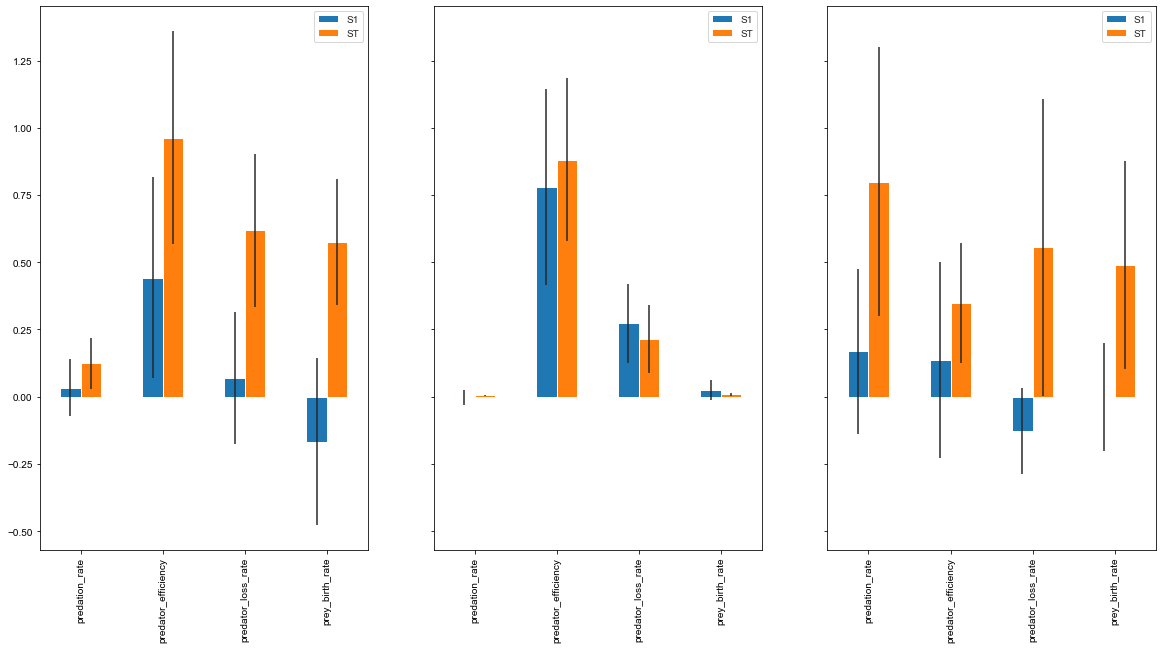

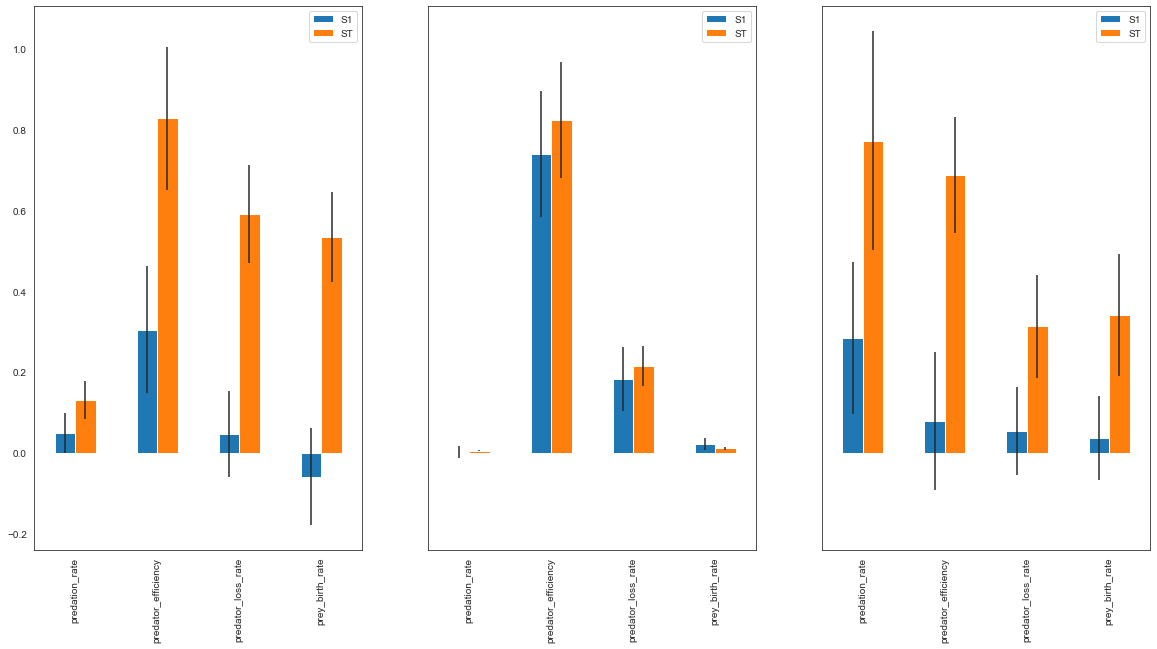

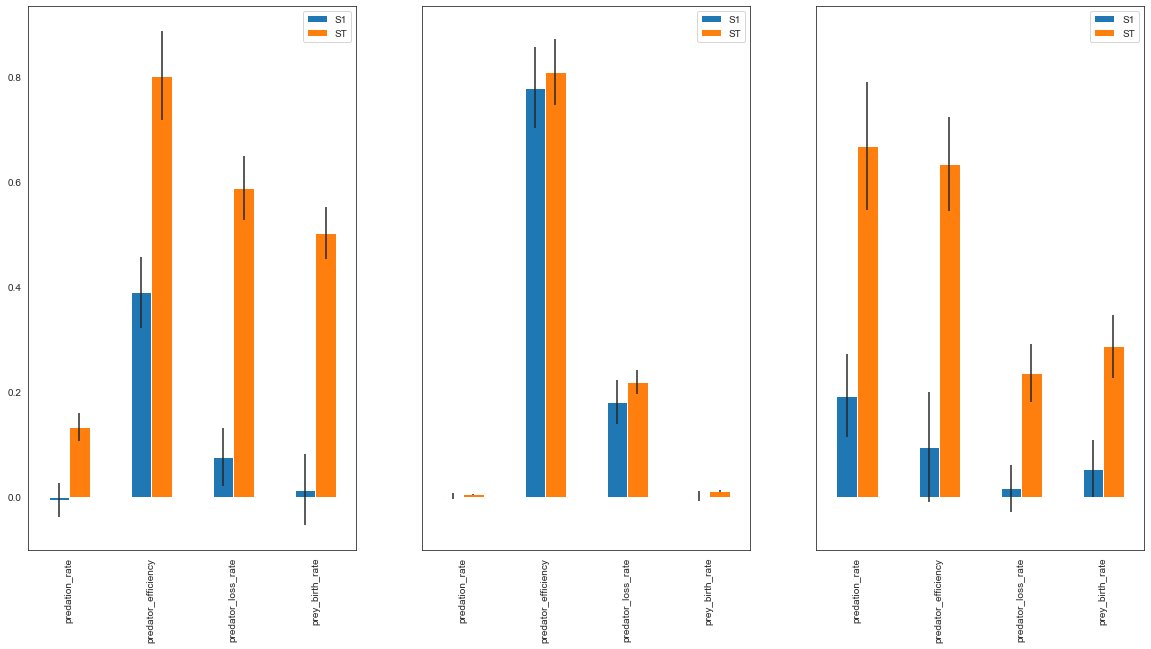

In [3]:
# GSA method: Sobol analysis


# Performs sobol analysis on experiment result (model_output) using SALib
def perform_SALib_sobol(model, model_output, output_name, subplot):
    # Returns a dict with a problem specificatin as required by SALib
    problem = get_SALib_problem(model.uncertainties)
    Si = sobol.analyze(problem, model_output, calc_second_order=True, print_to_console=False)

    # If the total-order indices are substantially larger than the first-order indices,
    # then there is likely higher-order interactions occurring. We can look at the second-order indices
    # to see these higher-order interactions

    scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(scores_filtered, index=problem['names'])
    Si_df.sort_values(by='ST',ascending=False)

    sns.set_style('white')

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=subplot)

    print("\n" + output_name)

    print("")

    print(Si_df)

# Performs experiment using EMA workbench on a specified model instance for N scenarios
def perform_EMA_sobol_experiment(model, N):

    model.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                         RealParameter('predation_rate', 0.0005, 0.003),
                         RealParameter('predator_efficiency', 0.001, 0.004),
                         RealParameter('predator_loss_rate', 0.04, 0.08)]


    # We assume that Sobol sampling automatically performs N * (2D+2) scenarios.
    # Therefore, we do not perform this calculation.
    # number_uncertainties = 4
    # total_scenarios = N * (2*number_uncertainties + 2)

    total_scenarios = N

    model.outcomes = [TimeSeriesOutcome('TIME', function=np.squeeze),
                    TimeSeriesOutcome('predators', function=np.squeeze),
                    TimeSeriesOutcome('prey', function=np.squeeze)]

    # N * (2D+2) scenarios, where D is the number of uncertain parameters,
    # and N is the value for scenarios passed to perform_experiments

    experiments, outcomes = perform_experiments(model, scenarios=total_scenarios, uncertainty_sampling='sobol')

    # Store final values of prey outcome
    prey_final= []
    prey_mean = []
    prey_std = []

    # Iterate through rows of outcome numpy array (experiments) to calculate indicators
    for experiment_row in outcomes["prey"]:
        prey_final.append(experiment_row[-1]) # Get last element
        prey_mean.append(np.mean(experiment_row))
        prey_std.append(np.std(experiment_row))

    # Collect indicators in dictionary to calculate regression for each of them

    # Convert outputs to numpy array
    prey_final_np = np.array(prey_final)
    prey_mean_np = np.array(prey_mean)
    prey_std_np = np.array(prey_std)

    # Create plots including subplots
    fig1 = plt.figure()
    fig1.tight_layout()
    fig1.set_size_inches(20, 10)

    ax1 = fig1.add_subplot(131)
    ax2 = fig1.add_subplot(132, sharey=ax1)
    ax3 = fig1.add_subplot(133, sharey=ax1)

    # Perform sobol analysis on experiment result using SALib for every output of interest
    perform_SALib_sobol(model, prey_final_np, "Final value of prey", ax1)
    perform_SALib_sobol(model, prey_mean_np, "Mean value of prey", ax2)
    perform_SALib_sobol(model, prey_std_np, "Standard deviation of prey", ax3)

number_scenarios = 50
print("Performing {} scenarios:".format(number_scenarios))
perform_EMA_sobol_experiment(modelPython, number_scenarios)

number_scenarios = 250
print("Performing {} scenarios:".format(number_scenarios))
perform_EMA_sobol_experiment(modelPython, number_scenarios)

number_scenarios = 1000
print("Performing {} scenarios:".format(number_scenarios))
perform_EMA_sobol_experiment(modelPython, number_scenarios)

# Sobol analysis interpretation

How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices?

- The first-order indice (S1) evaluates the contribution of an input parameter to outcome of interest, whereas the total-order indice (ST) is the total contribution of the input parameter, including its interaction with other inputs, on the outcome. It can be observed in almost all the generated graphs that the ST value of input parameter is higher than its S1 value. This means that there is interaction effects and that the model under study is non-linear as the total variance of the outcomes of interest can be attributed to interaction between input parameters. However, there are exceptions (elaborated in the following bullet point). 

- The sample size has an impact on the S1 and St indices. Most noticebly, prey birth rate has a higher S1 than ST for  sample size N=50 and N=250, but for N=1000, it appears that the effect of prey birth rate on the output of mean value of prey is soley its interaction effects with other input parameters. It could sugges that the sample sizes are insufficient for a stable estimation of the indices.  

[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 25 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 35 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 45 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis 

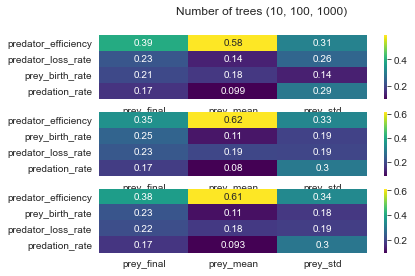

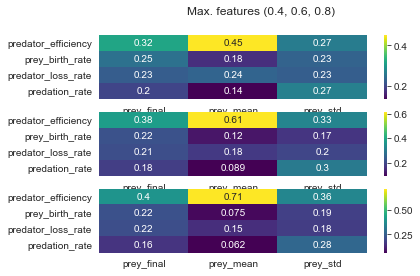

[MainProcess/INFO] performing 250 scenarios * 1 policies * 1 model(s) = 250 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 25 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 75 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 125 cases completed
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 175 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 225 cases completed
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
/Users/wenyuc/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[MainP

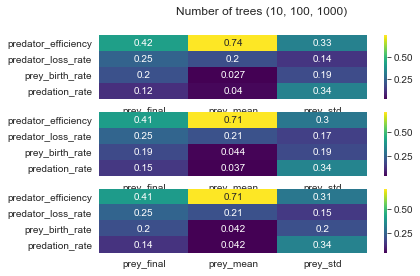

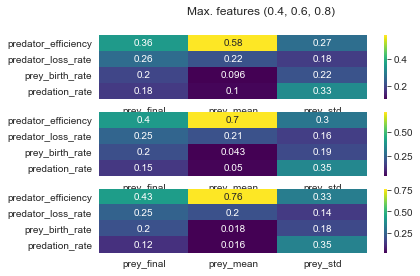

[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
/Users/wenyuc/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


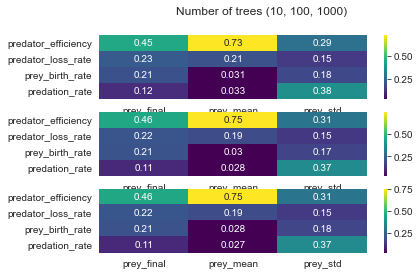

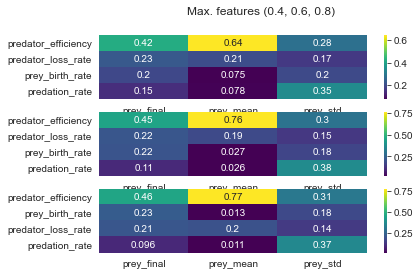

In [5]:
# GSA method: Extra-trees

def calculate_tree(input_data, output_data, column_name, nr_trees_input, nr_max_features_input):
    fs = feature_scoring.get_ex_feature_scores(input_data, output_data, mode=RuleInductionType.REGRESSION, nr_trees=nr_trees_input, max_features=nr_max_features_input)

    output_dataframe = fs[0]
    output_dataframe.columns = [column_name]

    # Extract dataframe from output tuple
    return fs[0]

def tree_generate_heatmap(inputs, final, mean, std, nr_trees_input, nr_max_features_input, subplot):
    output_prey_final = calculate_tree(inputs, final, "prey_final", nr_trees_input, nr_max_features_input)
    output_prey_mean = calculate_tree(inputs, mean, "prey_mean", nr_trees_input, nr_max_features_input)
    output_prey_std = calculate_tree(inputs, std, "prey_std", nr_trees_input, nr_max_features_input)

    # Concatenate dataframes to have all columns in one dataframe
    frames = [output_prey_final, output_prey_mean, output_prey_std]
    frames_together = pd.concat(frames, axis=1)

    # Plot heatmap
    sns.heatmap(frames_together, cmap='viridis', annot=True, ax=subplot)

def run_full_tree_experiment(model, number_samples):
    with SequentialEvaluator(model) as evaluator:
        experiments, outcomes = evaluator.perform_experiments(scenarios=number_samples, uncertainty_sampling=LHS)

    # Store final values of prey outcome
    prey_final = []
    prey_mean = []
    prey_std = []

    # Iterate through rows of outcome numpy array (experiments) to calculate indicators
    for experiment_row in outcomes["prey"]:
        prey_final.append(experiment_row[-1]) # Get last element
        prey_mean.append(np.mean(experiment_row))
        prey_std.append(np.std(experiment_row))


    # Convert outputs to numpy array
    prey_final_np = np.array(prey_final)
    prey_mean_np = np.array(prey_mean)
    prey_std_np = np.array(prey_std)

    # Feature scoring
    x = experiments

    fig1 = plt.figure()
    fig1.tight_layout()
    fig1.suptitle("Number of trees (10, 100, 1000)")
    ax1 = fig1.add_subplot(311)
    ax2 = fig1.add_subplot(312)
    ax3 = fig1.add_subplot(313)

    # Generate heatmaps for different parameters of tree number
    tree_generate_heatmap(x, prey_final_np, prey_mean_np, prey_std_np, 10, 0.6, ax1)
    tree_generate_heatmap(x, prey_final_np, prey_mean_np, prey_std_np, 100, 0.6, ax2)
    tree_generate_heatmap(x, prey_final_np, prey_mean_np, prey_std_np, 1000, 0.6, ax3)

    fig2 = plt.figure()
    fig2.tight_layout()
    fig2.suptitle("Max. features (0.4, 0.6, 0.8)")
    ax1 = fig2.add_subplot(311)
    ax2 = fig2.add_subplot(312)
    ax3 = fig2.add_subplot(313)

    # Generate heatmaps for different parameters of max. features
    tree_generate_heatmap(x, prey_final_np, prey_mean_np, prey_std_np, 100, 0.4, ax1)
    tree_generate_heatmap(x, prey_final_np, prey_mean_np, prey_std_np, 100, 0.6, ax2)
    tree_generate_heatmap(x, prey_final_np, prey_mean_np, prey_std_np, 100, 0.8, ax3)

    plt.show()

run_full_tree_experiment(modelPython, 50)
run_full_tree_experiment(modelPython, 250)
run_full_tree_experiment(modelPython, 1000)

# Extra-trees interpretation

- The findings are very robust against the number of trees. 100 trees provide a sufficient approximation. Increasing the number by 1-2 order of magnitudes does not change the results significantly.
- The effects of predator efficiency and its interactions with other uncertainties have the highest impact on the mean value of prey.
- We can see that the sample size has a significant impact on the relative sobol indices. Most noticebly, the tree model predicts a lower importance of the predator efficiency on the prey_mean value.

# General interpretation

Do you see differences in the three techniques? Do you know why these techniques give different outcomes?

- We observed different results from the three different GSA methods. This is because the sampling techniques differ between the three methods. Linear regression and Extra-trees utilize LHS, whereas Sobol analysis requires the specific Sobol sampling. 

- Extra-trees generate similar results as sobol analysis but at a much higher execution speed. Yet, unlike sobol, extra-trees do not provide insight into S1 values, and thus it only reveal the interaction effects of input parameters on outputs.

- Interestingly, all three methods share the same result in terms of showing that predator efficiency has signficant impacts on the mean values of prey over time.